In this notebook, I will use torch_geometric to predict the developpement of a graph of positions through time

In [1]:
"""
I realized I am leaning towards this approach https://doi.org/10.1016/j.trc.2020.102635
"""

'\nI realized I am leaning towards this approach https://doi.org/10.1016/j.trc.2020.102635\n'

In [2]:
# import torch
# from torch_geometric.nn import knn_graph

# import timeit

# timeit.timeit("knn_graph(torch.randn(1000, 3), k=10)", setup="from __main__ import knn_graph; import torch", number=10000)

In [3]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import pickle

import sys
import os
from genericpath import exists

from cell_dataset import CellGraphDataset, load, single_overfit_dataset
from cell_model import Gatv2Predictor, Gatv2PredictorDiscr, ConvPredictor
from cell_utils import GraphingLoss, make_animation
from cell_training import train, test_single, compute_parameters, run_single_recursive

import matplotlib.pyplot as plt

import os, psutil
process = psutil.Process(os.getpid())
print("Using : ", process.memory_info().rss // 1000000)  # in megabytes 
print("Available : ", process.memory_info().vms  // 1000000)  # in megabytes 

print(torch.cuda.is_available())

#https://github.com/clovaai/AdamP
from adamp import AdamP

sys.path.append('/home/nstillman/1_sbi_activematter/cpp_model')
try :
    import allium
except :
    print("Could not import allium")

Using :  491
Available :  43790
True
Cannot import zuko. Continuing without prior
No module named 'pycapmd'
Cannot import simulator


The data is a graph of cells having their own positions and velocity.

In the graph, we will first start by connecting all the edges, then maybe later make radius_graphs to reduce the cost of the pass through the model

In [4]:
load_all =  True #load directly from a pickle
pre_separated = False #if three subfolders already exist for train test and val

override = False #make this true to always use the same ones

extension = "_open_ht_hv"
number_of_messages = 2
size_of_messages = 128
absolute = 0
epochs = 600
distrib = "laplace"

name_complete = extension + "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + ("absolute" if absolute else "relative") + "_" + distrib

model_path = "models/model" + name_complete
loss_path = "models/loss" + name_complete

data_train, data_test, data_val = load(load_all, extension, pre_separated, override)

Validation data not found


In [5]:
#INFO : if bg_load is True, this starts the loading, if skipped, bg_loading will take place as soon as a get is called
rval, edge_index, edge_attr, border, params = data_train.get(0)
rval, edge_index, edge_attr, border, params = data_test.get(0)

print("Is data wrapped ? ", data_train.wrap)

print("Train size : ", data_train.len())

Is data wrapped ?  False
Train size :  900


Next we need to define the model that will be used :
    > input 
        (1) Graph at a particular time t (nodes having x,y,dx,dy as attributes)
        (2) Graphs up to a particular time [t-a, t] (nodes having x,y as attributes)
    > output
        (a) Graph at the immediate next time step t+1
        (b) Graph [t, t+b]
        (c) Graph at t+b
    > graph size
        (x) Fixed graph size to the most nodes possible (or above)
        (y) Unbounded graph size
            >> idea : graph walks
            >> idea : sampler

The following model will do (1ax)

In [6]:
def start(model : Gatv2Predictor, optimizer : torch.optim.Optimizer, scheduler  : torch.optim.lr_scheduler._LRScheduler,\
          data_train : CellGraphDataset, data_test : CellGraphDataset, device : torch.device, epoch : int, offset : int, grapher : GraphingLoss, save=0, save_datasets=True):
    
    loss_history_train = {"loss_mean" : [], "loss_log" : [], "loss" : []}
    loss_history_test_recursive = {"loss_mean" : [], "loss_log" : [], "loss" : []}
    for e in range(offset, offset + epoch):
        
        recursive = True

        train(model, optimizer, scheduler, data_train, device, e, process, max_epoch=offset+epoch, recursive=recursive, distrib=distrib)

        #model.show_gradients()
        
        if(e == 0 and save_datasets) :
            data_train.thread = None
            data_test.thread = None
            with open("data/training" + extension + ".pkl", 'wb') as f:
                pickle.dump(data_train, f)
            with open("data/testing" + extension + ".pkl", 'wb') as f:
                pickle.dump(data_test, f)
            print("Saved datasets")
        

        train_loss = test_single(model, data_train, device, loss_history_train, duration=10, recursive=False, distrib=distrib)
        test_loss_r = test_single(model, data_test, device, loss_history_test_recursive, duration=10, recursive=True, distrib=distrib)

        print("Epoch : ", e, "Train Loss", train_loss, "Test loss recursive : ", test_loss_r)

        grapher.plot_losses(title="Training", data=loss_history_train, length=min(50, len(data_train)), extension=name_complete + "_") 
        grapher.plot_losses(title="Testing recursive", data=loss_history_test_recursive, length=min(50, len(data_test)), extension=name_complete + "_") 
        
        if (e!=0 and e%save == 0) :      
            all_params_out, all_params_true = compute_parameters(model, data_test, device, duration=-1, distrib=distrib)
            grapher.plot_params(all_params_out, all_params_true, e, extension=name_complete)
        
        if (save and (e%save == 0 or e == epoch-1)) :
            torch.save(model.state_dict(), model_path + str(e) + ".pt")

In [7]:
load = True

epoch_to_load = 260

model = Gatv2Predictor(in_channels=12, out_channels=8, hidden_channels=size_of_messages, dropout=0.1, edge_dim=2, messages=number_of_messages, wrap=data_train.wrap, absolute=absolute)
#model = Gatv2Predictor(in_channels=9, out_channels=4, hidden_channels=32, dropout=0.01, edge_dim=2, messages=5, wrap=True)
#model = Gatv2PredictorDiscr(in_channels=9, out_channels=4, hidden_channels=16, dropout=0.01, edge_dim=2, messages=5, wrap=True)
#model = ConvPredictor(in_channels=16, out_channels=8, hidden_channels=size_of_messages, dropout=0.05, edge_dim=2, messages=number_of_messages, wrap=data_train.wrap, absolute=absolute, heads=4)

if exists(model_path + str(epoch_to_load) + ".pt") and load :
    model.load_state_dict(torch.load(model_path + str(epoch_to_load) + ".pt"))
    print("Loaded model")

Loaded model


In [8]:
#might want to investigate AdamP 
optimizer = AdamP(model.parameters(), lr=1e-9, betas=(0.9, 0.999), eps=1e-6, weight_decay=5e-3, delta=0.1, wd_ratio=0.1, nesterov=True)
scheduler = CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=10, T_mult=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
grapher = GraphingLoss()

model = model.to(device)

#all_params_out, all_params_true = compute_parameters(model.to(device), data_test, device, duration=0)
#grapher.plot_params(all_params_out, all_params_true, epoch_to_load, extension=extension)

In [10]:
start(model, optimizer, scheduler, data_train, data_test, device, \
        epochs, epoch_to_load, grapher=grapher, save=10, save_datasets=False)

Epoch :  260 Train Loss 0.05561247514353858 Test loss recursive :  24.958077201843263
Epoch :  261 Train Loss 0.055814089907540214 Test loss recursive :  24.464444427490236
Epoch :  262 Train Loss 0.05582831197314792 Test loss recursive :  24.182930183410644
Epoch :  263 Train Loss 0.05600735392835405 Test loss recursive :  24.767659645080567
Epoch :  264 Train Loss 0.0562022238307529 Test loss recursive :  23.836671829223633
Epoch :  265 Train Loss 0.05636941472689311 Test loss recursive :  24.43132350921631
Epoch :  266 Train Loss 0.05623321493466695 Test loss recursive :  25.145120010375976
Epoch :  267 Train Loss 0.056461706426408555 Test loss recursive :  24.849764709472655
Epoch :  268 Train Loss 0.05666499574979146 Test loss recursive :  24.65831027984619
Epoch :  269 Train Loss 0.056871645119455125 Test loss recursive :  24.422093315124513
Epoch :  270 Train Loss 0.05704538298977746 Test loss recursive :  24.867033004760742
Epoch :  271 Train Loss 0.05688428295983208 Test loss 

In [ ]:
epochs = 20

In [ ]:
all_params_out, all_params_true = compute_parameters(model, data_test, device, duration=-1, distrib=distrib)
grapher.plot_params(all_params_out, all_params_true, epochs - 1, extension=extension)

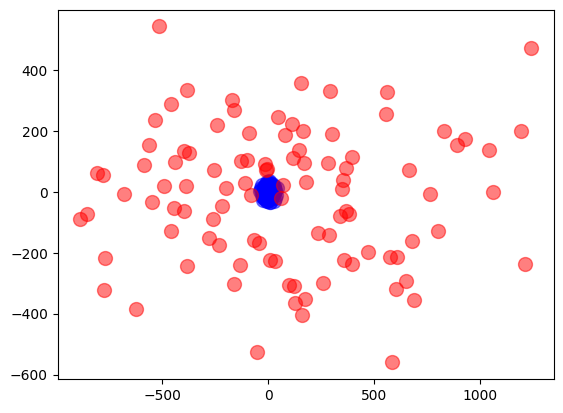

In [ ]:
loss, out, x = run_single_recursive(model, data_test, 0, device, output=True)

if x == None or out == None :
    print("No output")
    exit()

#make x the size of the output
x = x[:out.shape[0], :out.shape[1], :out.shape[2]]

out = out.detach().cpu().numpy()
x = x.detach().cpu().numpy()


result_name = "models/result_recursive" + name_complete + "_" + str(epochs-1) + ".pkl"

with open(result_name, "wb") as f:
    pickle.dump((out, x), f)

t = 10
fig = plt.figure()

#now plot the graph as bubbles to show the difference between the two
plt.scatter(x[t, :,0],x[t, :,1], s=100, c='b', alpha=0.5)
plt.scatter(out[t, :,0],out[t, :,1], s=100, c='r', alpha=0.5)

plt.show()
plt.close()

animation_name = "models/animation_recursive" + name_complete + "_" + str(epochs-1) + ".mp4"
make_animation(result_name, animation_name, show_speed=False)
